# Vector Space Model 
### Filippo Olivetti

## 1. Corpus preprocessing

In [1]:
# Importing dependancy libraries
import os
import pandas as pd
import numpy as np
import re
import math as m
from collections import Counter
import matplotlib.pyplot as plt

import pickle

from text_preprocessing import corpus_preprocessing
from create_index import create_index
from query_processing import search, vectorize_query

[nltk_data] Downloading package punkt to /home/pippo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Defining global variables for directories
source_file=os.getcwd()+"/data"
preprocessed_source_file=os.getcwd()+"/queries"
path=os.getcwd()

if not os.path.isdir(preprocessed_source_file):
    os.mkdir(preprocessed_source_file)


**Preprocessing Steps:**
We will do the following steps for both body text and zone text

- Transform the input text to lowercase.
- Remove punctuation, numbers.
- Exclude words with one or two characters in length.
- Perform Stemming.
- Tokenize words and add them to dictionary doc_id
- Eliminate stopwords.


The $\texttt{corpus\_preprocessing}$ function has the $\texttt{use\_zones}$ boolean variable that allows to consider title and bodies as distinct text portions. This will be useful when evaluating a query (more importance can be given if query is better aligned with a title).

In [ ]:
location = source_file + '/text_data.txt'
corpus_preprocessing(location)
"""
    Do a preprocessing on each document of the corpus
    :param location: address to the text corpus
    :return: None
    """

### Creating tf-idf dictionary.

Build $\texttt{DF}$ dictionary with pairs $\texttt{(token, number of occurences)}$.

Here I calculate the $\texttt{tf\_idf}= \texttt{tf}\times \texttt{idf}$ dictionary with all pairs $(\texttt{token, tf\_idf})$ where $$\texttt{tf}=\frac{\texttt{freq}_{t,d}}{\texttt{len}(d)}$$
 with $t$ token, $d$ document and $\texttt{freq}_{t,d}$ is the number of occurence of token $t$ in the document $d$;
$$
idf_t= \log \frac{N}{df_t}, 
$$ 
with $t$ token, $N$ number of docs and $df_t$ the document frequency of the token $t$.

Indexes are created for both title and body zones.

In [ ]:
# Store indexes and documents vector in pkl files
create_index()

In [3]:
# Importing the stored files
words = pd.read_pickle(r'./Storage/words.pkl')  # list of tokens found
idf = pd.read_pickle(r'./Storage/inv_doc_freq.pkl') # dict with idf scores for each token

# dict: for each document there is the vector representation in VSM
doc_vector = pd.read_pickle('./Storage/doc_vec.pkl', 'bz2')

# dict: for each documente there is its TITLE as string
zone = pd.read_pickle(r'./Storage/zone.pkl')

# dict: for each document TITLE there is the vector representation in VSM 
zone_vec = pd.read_pickle(r'./Storage/zone_vec.pkl')

In [4]:
print(f'Number of documents in the corpus is {len(doc_vector)}')
zone

Number of documents in the corpus is 445


{12: 'Anarchism',
 25: 'Autism',
 39: 'Albedo',
 290: 'A',
 303: 'Alabama',
 305: 'Achilles',
 307: 'Abraham Lincoln',
 308: 'Aristotle',
 309: 'An American in Paris',
 316: 'Academy Award for Best Production Design',
 324: 'Academy Awards',
 330: 'Actrius',
 332: 'Animalia (book)',
 334: 'International Atomic Time',
 336: 'Altruism',
 339: 'Ayn Rand',
 340: 'Alain Connes',
 344: 'Allan Dwan',
 358: 'Algeria',
 359: 'List of Atlas Shrugged characters',
 569: 'Anthropology',
 572: 'Agricultural science',
 573: 'Alchemy',
 580: 'Astronomer',
 586: 'ASCII',
 593: 'Animation',
 594: 'Apollo',
 595: 'Andre Agassi',
 597: 'Austroasiatic languages',
 599: 'Afroasiatic languages',
 600: 'Andorra',
 612: 'Arithmetic mean',
 615: 'American Football Conference',
 620: 'Animal Farm',
 621: 'Amphibian',
 624: 'Alaska',
 627: 'Agriculture',
 628: 'Aldous Huxley',
 630: 'Ada',
 633: 'Algae',
 634: 'Analysis of variance',
 639: 'Alkane',
 640: 'Appellate procedure in the United States',
 642: 'Answer'

## 2. Querying the corpus

### Query preprocessing

In [5]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Initiallizing Porter Stemmer object
st = PorterStemmer()

# Intializing stopwords list
stop_list = stopwords.words('english')

def query_preprocessing(query):
    """
    Remove all punctuation and special characters
        -query: query
    return 
        query_words: tokenized query terms as list
    """

    query = query.lower()
    query = query.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    query = query.translate(str.maketrans("‘’’–——−", '       '))
    query_list = [st.stem(word) for word in query.split() if word not in stop_list]
    query = ' '.join(query_list)

    # Tokenizing the query
    query_words = []
    query_words = word_tokenize(query)
    query_words = list(set(query_words))

    return query_words

In [6]:
query_preprocessing('The cat is on the table now')

['cat', 'tabl']

### Query resolution

After the preprocessing, we define the cosine similarity between two vectors using the $\texttt{cosine\_similarity} $ function. This function takes two numpy arrays as input and returns the cosine similarity between them. $\texttt{cosine\_similarity} $ is used in $\texttt{get\_scores} $ function that compute the query vector and return the scores with all documents.

The function $\texttt{vectorize\_query} $ creates a vector from a preprocessed query.

We will also define the $\texttt{search}$ function, which will determine a ranked list of top k documents based on their cosine similarity with a given query.


In [7]:
# vectorize_query(preprocessed_query)
# cosine_similarity(x, y)

# search(preprocessed_query, is_vec=False, imp_factor=1.75, top=10, use_zones=True):
"""
Searching a free text query to print top 10 doc ids, with their score and title
    -preprocessed_query: preprocessed query
    -is_vec: True if query is already vectorized
    -imp_factor: float, should be greater than 1 if we want to give more importance to zones
    -use_zones: set to True to enable Zonal indexing
    -top: int find the first top documents satisfying the query
return: 
    -scored_doc_ids: documents ranking
"""

'\nSearching a free text query to print top 10 doc ids, with their score and title\n    -preprocessed_query: preprocessed query\n    -is_vec: True if query is already vectorized\n    -imp_factor: float, should be greater than 1 if we want to give more importance to zones\n    -use_zones: set to True to enable Zonal indexing\n    -top: int find the first top documents satisfying the query\nreturn: \n    -scored_doc_ids: documents ranking\n'

## 3. Vector Model Evaluation: precision and recall.

For the evaluation we consider the $\texttt{relevance.txt}$, created by myself. In this documents I create 5 queries and found in the corpus the relevant documents that talk about each query.

In [8]:
# Get the relevance of each document for each query
column_names = ['Query_ID', 'Relevance']
relevance_df = pd.read_csv(f"{path}/queries/relevance.txt", delim_whitespace=True, names=column_names, header=1)
relevance_df['Relevance']=relevance_df['Relevance'].astype(int)
print(relevance_df.head())

# Open file with queries created by myself
query_file = open(path+'/queries/queries.txt', 'r')
queries = query_file.readlines()
query_file.close()

# Preprocess each query
for i, query in enumerate(queries):
    queries[i] = query_preprocessing(query)

# Print the (ground truth) relevant documents for each query in relevance.txt
query_relevance_lists = []
for query_id in range(len(queries)):
    relevant_documents = relevance_df[relevance_df['Query_ID'] == query_id]['Relevance'].to_list()
    query_relevance_lists.append(relevant_documents)
    print(f'\nRelevant docs for query {query_id} is: {relevant_documents}\n')

   Query_ID  Relevance
0         0       1181
1         0       1317
2         0        798
3         0        799
4         1        305

Relevant docs for query 0 is: [1181, 1317, 798, 799]


Relevant docs for query 1 is: [305, 594, 1174, 1182]


Relevant docs for query 2 is: [863]


Relevant docs for query 3 is: [1315, 1485, 1409, 1485, 1520, 752, 1078, 1178, 1400]


Relevant docs for query 4 is: [627, 951, 1082]



In [9]:
# Set hyperparameters, k will be use when calculating precision/recall at k, and 
# imp_factor is the importance given to the title!
k = 7
imp_factor = 2

In [10]:
# Now, use the search function, that relies on index we created at the beginning
print(queries)
for query_id in range(len(queries)):
        top_k_documents = search(queries[query_id], imp_factor=imp_factor, top=10, use_zones=True)
        print(top_k_documents)

[['studi', 'astronom', 'star', 'supernova'], ['ancient', 'greek', 'cultur', 'iliad'], ['warfar', 'trench'], ['age', 'cathol', 'religion', 'middl'], ['place', 'grow', 'orang']]
[(580, 0.23252900317216615), (1210, 0.14338713441578474), (1181, 0.1201318537853448), (748, 0.1058280605177896), (1394, 0.08665754004785214), (799, 0.08427303413042035), (798, 0.07898525668307303), (1317, 0.06624210781297954), (1196, 0.052621819894848196)]
[(1167, 0.08962293396455848), (874, 0.08192666317151877), (305, 0.07502034830071853), (1174, 0.06466331364561477), (689, 0.054157181699516756), (594, 0.053766128953729925), (1182, 0.053389774033817325), (929, 0.052303729691066586), (1212, 0.051040680636778635)]
[(698, 0.037343154472463565), (1336, 0.033767051888436136), (1183, 0.0327392073219054), (863, 0.03162418749997383), (1203, 0.027353145690223242), (1376, 0.024828405956801657), (680, 0.02340117304392388), (1088, 0.022662938066070223), (1354, 0.021846965605683652), (307, 0.0213171528479345)]
[(1092, 0.1103

### R-precision

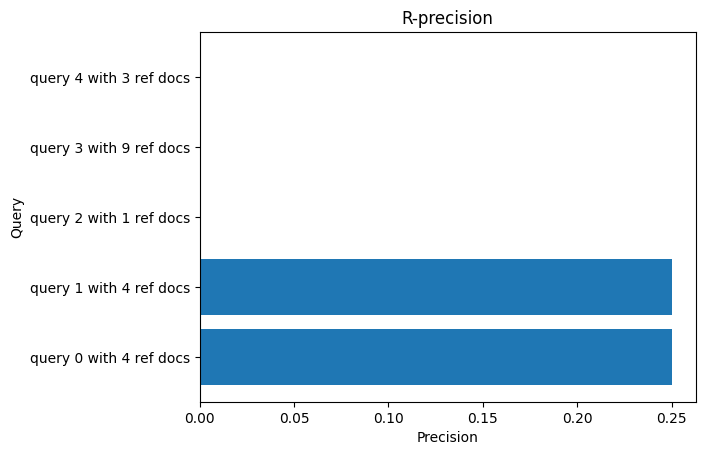

In [11]:
# Calculating the precision of the first r retrieved documents
def r_precision(query_id, imp_factor=1.75, r=10):
    """
    Calculate recall values for each query given the number of top documents to be retrieved (k).

    Args:
        k (int): Number of top documents to be retrieved.

    Returns:
        list: List of recall values for each query.
    """

    relevant_documents = query_relevance_lists[query_id] # Solution
    top_k_documents = search(queries[query_id], imp_factor=imp_factor, top=r, use_zones=True)

    # Number of relevant documents retrieved
    intersect_count = len([tup[0] for tup in top_k_documents if tup[0] in relevant_documents])
    # Total number of relevant documents
    total_relevant_documents = len(relevant_documents)
    # Calculate recall for the current query
    precision = intersect_count / total_relevant_documents if total_relevant_documents > 0 else 0

    return precision

precision_values = []
for query_id in range(len(queries)):
    precision_values.append(r_precision(query_id, imp_factor=imp_factor, r=len(query_relevance_lists[query_id])))

# Plot r-precisions
y=[f'query {i} with {len(query_relevance_lists[i])} ref docs' for i in range(len(queries))]
plt.barh(y, precision_values)
# setting label of y-axis
plt.ylabel("Query")
 
# setting label of x-axis
plt.xlabel("Precision") 
plt.title("R-precision")
plt.show()

### Recall at k

In the following snippet we calculate the recall for a given k (the number of retrieved documents).

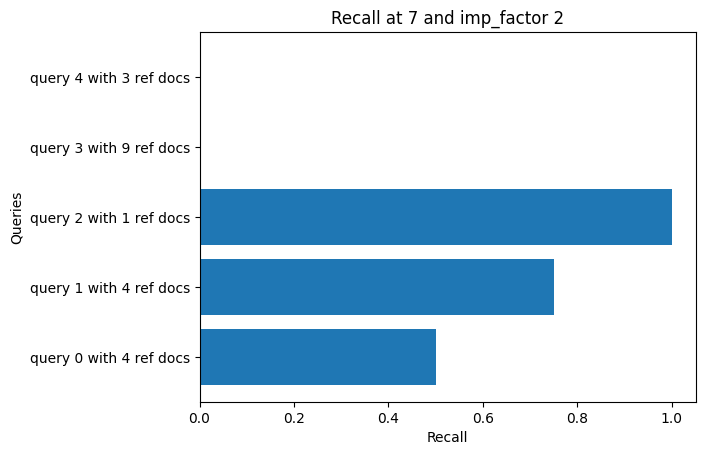

In [12]:
# Calculating recall= number of relevant documents retrieved/total number of relevant documents
# Get the relevance of each document for each query
def calculate_recall_at_k(imp_factor=2, k=10):
    """
    Calculate recall values for each query given the number of top documents to be retrieved (k).

    Args:
        k (int): Number of top documents to be retrieved.

    Returns:
        list: List of recall values for each query.
    """
    recall_values = []

    for query_id in range(len(queries)):
        relevant_documents = query_relevance_lists[query_id] # Solution
        top_k_documents = search(queries[query_id], imp_factor=imp_factor, top=k, use_zones=True)

        # Number of relevant documents retrieved
        intersect_count = len([tup[0] for tup in top_k_documents if tup[0] in relevant_documents])

        # True pos + False neg
        total_relevant_documents = len(relevant_documents)

        # Calculate recall for the current query
        recall = intersect_count / total_relevant_documents if total_relevant_documents > 0 else 0
        recall_values.append(recall)

    return recall_values


recall_results = calculate_recall_at_k(imp_factor=imp_factor, k=k)
#rounding off to 2 decimal places
recall_results = [round(num, 3) for num in recall_results]
# Plot r-precisions
y=[f'query {i} with {len(query_relevance_lists[i])} ref docs' for i in range(len(queries))]
plt.barh(y, recall_results)
# setting label of y-axis
plt.ylabel("Queries")

# setting label of x-axis
plt.xlabel(f"Recall") 
plt.title(f"Recall at {k} and imp_factor {imp_factor}")
plt.show()

### Precision at k

In the following snippet we calculate the precision for a given k (the number of retrieved documents).

In [13]:
#Calculating precision= number of relevant documents retrieved/total number of documents retrieved
def calculate_precision_at_k(imp_factor=2, k=10):
    """To generate list of precision values for each query for given value of k
    
    Arguments:
        k {[type]} -- number of top documents to be retrieved
    
    Returns:
        list -- list of precision values for each query
    """
    precision_values = []
    for query_id in range(len(queries)):
        relevant_documents = query_relevance_lists[query_id] # Solution
        top_k_documents = search(queries[query_id], imp_factor=imp_factor, top=k, use_zones=True)

        # Number of relevant documents retrieved
        intersect_count = len([tup[0] for tup in top_k_documents if tup[0] in relevant_documents])

        # Calculate recall for the current query
        precision = intersect_count / k
        precision_values.append(precision)

    return precision_values

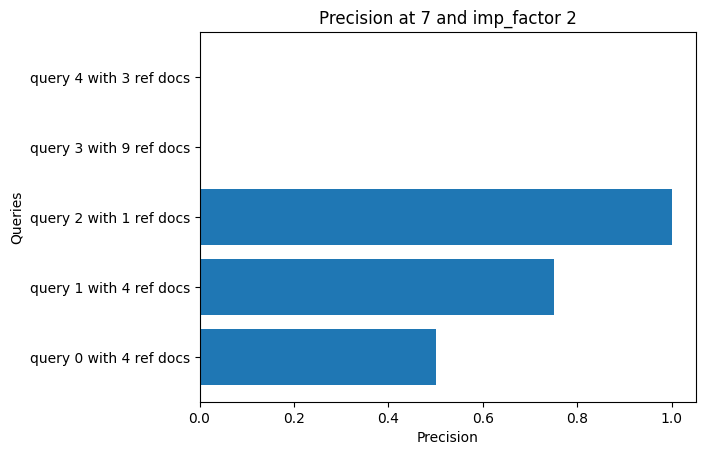

In [14]:
precision_results = calculate_recall_at_k(imp_factor=imp_factor, k=k)
#rounding off to 2 decimal places
precision_results = [round(num, 3) for num in precision_results]
# Plot r-precisions
y=[f'query {i} with {len(query_relevance_lists[i])} ref docs' for i in range(len(queries))]
plt.barh(y, precision_results)
# setting label of y-axis
plt.ylabel("Queries")

# setting label of x-axis
plt.xlabel(f"Precision") 
plt.title(f"Precision at {k} and imp_factor {imp_factor}")
plt.show()

## 4. Relevance Feedback

In the following snippets I will implement the Rocchio algorithm to improve the information retrieval systems. The feedback information are given REAL-TIME by the users after having seen the query answer! 

In [15]:
# ROCCHIO ALGORITHM
# Initializing alpha, beta, gamma values
alpha = 1
beta = 3 #0.75
gamma = 0.15

# Calculate centroid of relevant/irrelevant documents
def calculate_centroid(corpus, docus_list):
    """
    Calculate centroid of relevant/irrelevant documents.

    Args:
        corpus (dict): documents.
        docus_list (list of doc_id): list of (doc_id), result of search function

    Returns:
        numpy.ndarray: Centroid vector of relevant documents.
    """
    if len(docus_list) == 0:
        return 0.
    
    n_docs = len(docus_list)
    centroid = np.zeros_like(corpus[344])

    for index in docus_list:
        centroid += corpus[index]

    return 1/n_docs * centroid


def calculate_new_query_vector(query, non_relevant_docs_indexes ,alpha=1, beta=0.75, gamma=0.15):
    """
    Calculate new query vector based on Rocchio algorithm.

    Args:
        query_id (int): Query ID.
        relevant_documents_index (list): List of indexes relevant documents.
        alpha (float): Weight for the original query vector.
        beta (float): Weight for the centroid of relevant documents.
        gamma (float): Weight for the centroid of non-relevant documents.

    Returns:
        numpy.ndarray: New query vector.
    """
    original_query_vector = vectorize_query(query)
    doc_list = [tup for tup in doc_vector]

    # Get the list of relevant and non-relevant document IDs for the current query
    relevant_docs_indexes= [doc_id for doc_id in doc_list if doc_id not in non_relevant_docs_indexes]
    
    # Calculate Rocchio algorithm components
    relevant_centroid = calculate_centroid(doc_vector, relevant_docs_indexes)
    non_relevant_centroid = calculate_centroid(doc_vector, non_relevant_docs_indexes)

    # Calculate new query vector using Rocchio algorithm
    new_query_vector = alpha * original_query_vector + beta * relevant_centroid - gamma * non_relevant_centroid

    return new_query_vector


### Interactive example

**Write a query**

In [16]:
query = input('Write a query')
preprocessed_query = query_preprocessing(query)
print(query)
print(preprocessed_query)

first world war
['first', 'war', 'world']


**See top 10 documents retrieved**

In [17]:
top_answ = search(preprocessed_query=preprocessed_query, top=10)
print(top_answ)

[(1074, 0.1612317853384445), (863, 0.13750738080623304), (771, 0.1319034637853053), (892, 0.12862642908257138), (784, 0.12188069396878759), (924, 0.10669217725537102), (705, 0.10592344197825616), (1193, 0.10279856631056003), (1110, 0.10163118140309275)]


In [18]:
top_answ_indexes = [tup[0] for tup in top_answ]
for i in top_answ_indexes:
    print(f'Title of DocID {i} is: ' + str(zone[i]))

Title of DocID 1074 is: Royal Antigua and Barbuda Defence Force
Title of DocID 863 is: American Civil War
Title of DocID 771 is: American Revolutionary War
Title of DocID 892 is: Alfons Maria Jakob
Title of DocID 784 is: Alfred Korzybski
Title of DocID 924 is: A. A. Milne
Title of DocID 705 is: Politics of Angola
Title of DocID 1193 is: Agrarianism
Title of DocID 1110 is: Demographics of American Samoa


**Perform relevance feedback!**

In [19]:
from IPython.display import clear_output

user_input = [1]
index = 0
while len(user_input) > 0:
    index += 1
    user_input = []
    user_input = input('Write the list of NON-relevant DocIDs; write p if you are done:')
    if index % 3 == 0:
        clear_output(wait=True)
    if user_input == 'p':
        break
    user_input = list(map(int, user_input.split(',')))
    print(user_input)
    if not all(isinstance(x, int) for x in user_input):
        continue

    # Evaluate new query vector and new answers
    new_query_vec = calculate_new_query_vector(query, user_input)
    new_output = search(new_query_vec, is_vec=True, top=10)
    t_indexes = [tup[0] for tup in new_output]
    for i in t_indexes:
        print(f'Title of DocID {i} is: ' + str(zone[i]))
    

[924, 705]
Title of DocID 848 is: Audi
Title of DocID 752 is: Art
Title of DocID 670 is: Alphabet
Title of DocID 775 is: Algorithm
Title of DocID 791 is: Asteroid
Title of DocID 634 is: Analysis of variance
Title of DocID 1494 is: Alfred Russel Wallace
Title of DocID 1164 is: Artificial intelligence
Title of DocID 1338 is: Americans with Disabilities Act of 1990
Title of DocID 1214 is: Anglicanism


Now we can evaluate the performance in the same way as before. Obviously by considering the solution as feedback and high value of $\beta$ (which represents the weight of the centroid given by the feedback) we obtain better results.

## 5. Pseudo Relevance Feedback


In the following snippet I implement the pseudo relevance feedback: the idea is to assume the top $k$ document retrieved by our vector model as feedback information and then update the query vector with this information as done before.

We set the same k and imp_factor as in the model evaluation section: now precision and recall are higher!

### Recall at k with Pseudo-feedback

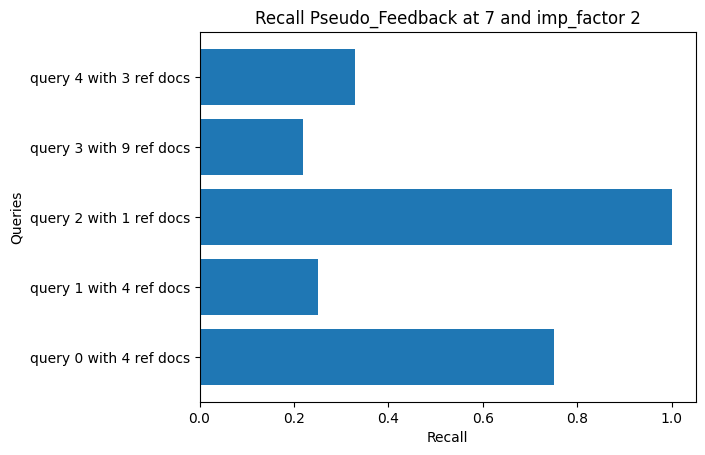

In [20]:
# Calculating recall= number of relevant documents retrieved/total number of relevant documents

# Get the relevance of each document for each query
def calculate_recall_at_k_with_pseudo_feedback(imp_factor=2, k=10):
    """
    Calculate recall values for each query given the number of top documents to be retrieved (k).

    Args:
        k (int): Number of top documents to be retrieved.

    Returns:
        list: List of recall values for each query.
    """
    recall_values = []
    for query_id in range(len(queries)):
        relevant_documents = query_relevance_lists[query_id] # Solution
        top_k_documents = search(queries[query_id], imp_factor=imp_factor, top=k, use_zones=True)
    
        new_query = calculate_new_query_vector(queries[query_id], [])

        top_k_documents = search(new_query, is_vec=True, top=k)

        # Number of relevant documents retrieved
        intersect_count = len([tup[0] for tup in top_k_documents if tup[0] in relevant_documents])

        # Total number of relevant documents
        total_relevant_documents = len(relevant_documents)

        # Calculate recall for the current query
        recall = intersect_count / total_relevant_documents
        recall_values.append(recall)

    return recall_values

#rounding off to 2 decimal places
recall_results = [round(num, 2) for num in calculate_recall_at_k_with_pseudo_feedback(imp_factor=imp_factor, k=k)]

# Plot recall pseudo-feedback
y=[f'query {i} with {len(query_relevance_lists[i])} ref docs' for i in range(len(queries))]
plt.barh(y, recall_results)
# setting label of y-axis
plt.ylabel("Queries")

# setting label of x-axis
plt.xlabel(f"Recall") 
plt.title(f"Recall Pseudo_Feedback at {k} and imp_factor {imp_factor}")
plt.show()

### Precision at k with Pseudo-feedback

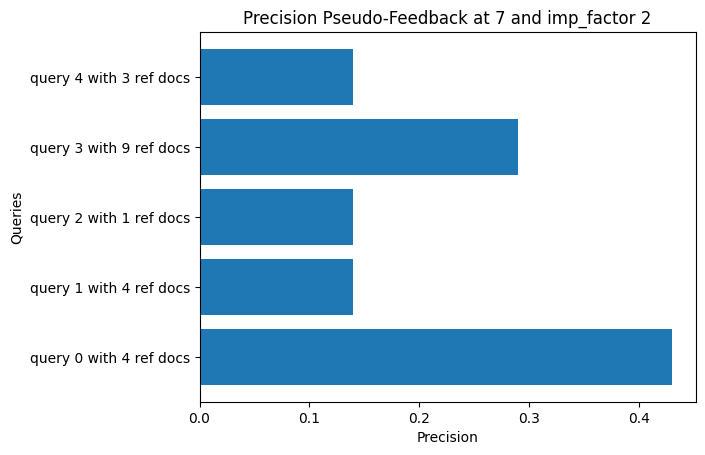

In [21]:
# Calculating recall= number of relevant documents retrieved/total number of relevant documents

# Get the relevance of each document for each query
def calculate_precision_at_k_with_pseudo_feedback(imp_factor=2, k=10):
    """
    Calculate precision values for each query given the number of top documents to be retrieved (k).

    Args:
        k (int): Number of top documents to be retrieved.

    Returns:
        list: List of recall values for each query.
    """
    precision_values = []
    for query_id in range(len(queries)):
        relevant_documents = query_relevance_lists[query_id] # Solution
        top_k_documents = search(queries[query_id], imp_factor=imp_factor, top=k, use_zones=True)
    
        new_query = calculate_new_query_vector(queries[query_id], [])
        top_k_documents = search(new_query, is_vec=True, top=k)

        # Number of relevant documents retrieved
        intersect_count = len([tup[0] for tup in top_k_documents if tup[0] in relevant_documents])

        # Total number of relevant documents
        precision = intersect_count / k
        precision_values.append(precision)

    return precision_values

#rounding off to 2 decimal places
precision_results = [round(num, 2) for num in calculate_precision_at_k_with_pseudo_feedback(imp_factor=imp_factor, k=k)]

# Plot precision pseudo-feedback
y=[f'query {i} with {len(query_relevance_lists[i])} ref docs' for i in range(len(queries))]
plt.barh(y, precision_results)
# setting label of y-axis
plt.ylabel("Queries")

# setting label of x-axis
plt.xlabel(f"Precision") 
plt.title(f"Precision Pseudo-Feedback at {k} and imp_factor {imp_factor}")
plt.show()